<a href="https://colab.research.google.com/github/ndndndn1/utils/blob/main/ETCH_profile_ray_251002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab-ready: Raycast using global mean threshold (angles a=90..270, theta=1deg)
# Usage:
# 1) 런타임에서 이 셀을 실행하면 파일 업로드 UI가 뜹니다.
# 2) SEM 이미지 파일을 업로드(예: input.png). 또는 파일명/경로를 직접 지정하세요.
# 3) (선택) 빨간 마커가 없으면 SRC_COORD = (x, y) 에 수동좌표를 넣으세요.
#
# Outputs:
# - /content/sem_raycast_globalmean.csv  (columns: angle_deg, r_pixels, x, y, method, value)
# - Figures shown inline: overlay + r vs angle

# --- 준비(Colab 파일 업로드) ---
try:
    # in Colab environment: show upload widget
    from google.colab import files
    print("Please upload your SEM image (click and select). Recommended filename: input.png")
    uploaded = files.upload()  # user selects files (can upload one)
    # pick the first uploaded file
    if len(uploaded) == 0:
        raise Exception("No file uploaded. Set filename manually.")
    filename = list(uploaded.keys())[0]
    print("Uploaded:", filename)
except Exception as e:
    # not Colab or user prefers manual file: set filename here
    print("Warning / info:", e)
    filename = "input.png"  # change if needed

# --- 의존성 설치 (필요하면) ---
# (Colab에는 보통 opencv, numpy, matplotlib, scipy 가 설치되어 있음. 필요시 아래 주석 제거)
# !pip install opencv-python-headless numpy matplotlib scipy

Please upload your SEM image (click and select). Recommended filename: input.png


Saving redDot.png to redDot.png
Uploaded: redDot.png


Global mean (grayscale) = 117.5781
Saved CSV to: /content/sem_raycast_globalmean.csv | Detected points: 181


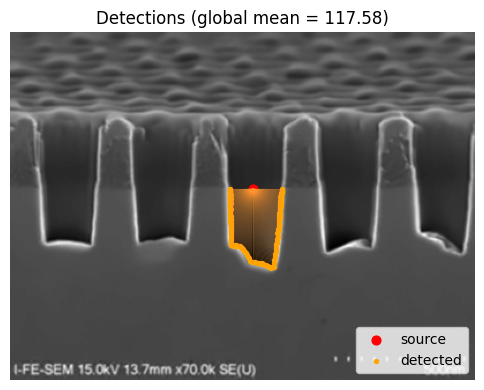

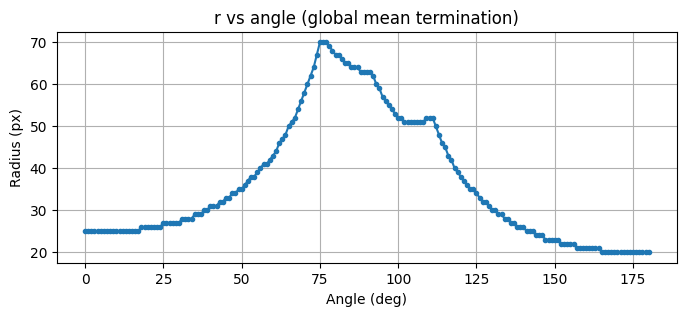

Sample rows (first 10):
{'angle_deg': 0.0, 'r_pixels': 25.0, 'x': 235.0, 'y': 136.0, 'method': 'global_mean', 'value': 143.0}
{'angle_deg': 1.0, 'r_pixels': 25.0, 'x': 234.99619237890977, 'y': 136.4363101609321, 'method': 'global_mean', 'value': 143.754584068067}
{'angle_deg': 2.0, 'r_pixels': 25.0, 'x': 234.9847706754774, 'y': 136.87248741756252, 'method': 'global_mean', 'value': 144.2728657749242}
{'angle_deg': 3.0, 'r_pixels': 25.0, 'x': 234.96573836886435, 'y': 137.3083989060736, 'method': 'global_mean', 'value': 144.54412099737954}
{'angle_deg': 4.0, 'r_pixels': 25.0, 'x': 234.9391012564956, 'y': 137.74391184360314, 'method': 'global_mean', 'value': 144.55465934201655}
{'angle_deg': 5.0, 'r_pixels': 25.0, 'x': 234.90486745229364, 'y': 138.17889356869145, 'method': 'global_mean', 'value': 144.2965270098216}
{'angle_deg': 6.0, 'r_pixels': 25.0, 'x': 234.86304738420682, 'y': 138.61321158169133, 'method': 'global_mean', 'value': 143.7599585278537}
{'angle_deg': 7.0, 'r_pixels': 25.0, 

In [3]:


# --- 라이브러리 불러오기 ---
import cv2
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os

# --- 사용자 설정 ---
SRC_COORD = None          # (x, y) 수동 좌표. 빨간 마커가 없고 직접 지정하려면 예: (210, 136)
THETA_DEG = 1.0          # theta = 1 degree
A_MIN = 0               # a start. +x clockwise
A_MAX = 180              # a end
OUTPUT_CSV = "/content/sem_raycast_globalmean.csv"

# --- 이미지 로드 및 전처리 ---
if not os.path.exists(filename):
    raise FileNotFoundError(f"Image file not found: {filename}")

# 읽을 때 컬러로 읽어 빨간 마커 유무 검사 가능하게 함
img_bgr = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
if img_bgr is None:
    raise RuntimeError("Failed to read image. Check file and path.")

# if image has alpha, drop alpha
if img_bgr.ndim == 3 and img_bgr.shape[2] >= 4:
    img_bgr = img_bgr[:, :, :3].copy()
# grayscale for intensity checks
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape

# global mean (criterion)
global_mean = float(np.mean(img_gray))
print(f"Global mean (grayscale) = {global_mean:.4f}")

# small preprocessing used for sampling (denoise + small blur)
img_dn = cv2.fastNlMeansDenoising(img_gray, h=8, templateWindowSize=7, searchWindowSize=21)
img_proc = cv2.GaussianBlur(img_dn, (3,3), 0)

# --- source(시작점) 결정: 빨간 마커 자동 탐지 (없으면 SRC_COORD 또는 fallback) ---
red_found = False
src_x = None; src_y = None
if img_bgr.ndim == 3:
    # convert to RGB to inspect red
    img_rgb = img_bgr[:, :, ::-1]
    r_chan = img_rgb[:, :, 0].astype(int)
    g_chan = img_rgb[:, :, 1].astype(int)
    b_chan = img_rgb[:, :, 2].astype(int)
    # heuristic red mask
    mask_red = (r_chan > 150) & (g_chan < 120) & (b_chan < 120)
    ys, xs = np.where(mask_red)
    if len(xs) > 0:
        src_x, src_y = int(np.mean(xs)), int(np.mean(ys))
        red_found = True

if not red_found:
    if SRC_COORD is not None:
        src_x, src_y = SRC_COORD
        red_found = False
        print("Using user-specified SRC_COORD:", SRC_COORD)
    else:
        # fallback heuristic: choose a plausible ROI center (near mid-top region)
        src_x = w // 2
        src_y = int(h * 0.35)
        print("No red marker found; using heuristic source:", (src_x, src_y))

# --- Raycast parameters (angles a*theta for a in [A_MIN..A_MAX]) ---
angles = np.arange(A_MIN, A_MAX + 1e-9, THETA_DEG)  # e.g. 90..270 by 1 deg
max_radius = int(math.hypot(max(src_x, w-src_x), max(src_y, h-src_y)))
min_detect_radius = 1.0  # ignore r == 0; set >0 to avoid source pixel

# utility: bilinear sampling along a ray (vectorized)
def sample_along_ray(xs, ys, img):
    """Bilinear sample image at float coordinates (xs, ys). Returns 1D array of intensities."""
    h, w = img.shape
    x0 = np.floor(xs).astype(int); y0 = np.floor(ys).astype(int)
    x1 = np.clip(x0 + 1, 0, w-1); y1 = np.clip(y0 + 1, 0, h-1)
    wx = xs - x0; wy = ys - y0
    I00 = img[y0, x0].astype(float); I10 = img[y0, x1].astype(float)
    I01 = img[y1, x0].astype(float); I11 = img[y1, x1].astype(float)
    intens = (1-wx)*(1-wy)*I00 + wx*(1-wy)*I10 + (1-wx)*wy*I01 + wx*wy*I11
    return intens

# run raycast
results = []
for ang in angles:
    th = math.radians(ang)  # interpret ang as degrees measured from +x axis towards +y (image coords)
    rs = np.arange(0, max_radius, 1.0)
    xs = src_x + rs * math.cos(th)
    ys = src_y + rs * math.sin(th)
    valid = (xs >= 0) & (xs < w) & (ys >= 0) & (ys < h)
    if not np.any(valid):
        continue
    xs_v = xs[valid]; ys_v = ys[valid]; rs_v = rs[valid]
    intens = sample_along_ray(xs_v, ys_v, img_proc)
    # termination criterion: first intensity > global_mean
    idxs = np.where(intens > global_mean)[0]
    chosen = None
    if idxs.size > 0:
        for ii in idxs:
            if rs_v[ii] >= min_detect_radius and rs_v[ii] > 0:
                chosen = ii
                break
    if chosen is not None:
        r_px = float(rs_v[chosen])
        x_px = float(xs_v[chosen]); y_px = float(ys_v[chosen])
        results.append({
            "angle_deg": float(ang),
            "r_pixels": r_px,
            "x": x_px,
            "y": y_px,
            "method": "global_mean",
            "value": float(intens[chosen])
        })

# --- Save CSV ---
keys = ["angle_deg","r_pixels","x","y","method","value"]
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=keys)
    writer.writeheader()
    for r in results:
        writer.writerow(r)
print("Saved CSV to:", OUTPUT_CSV, "| Detected points:", len(results))

# --- Visualization: overlay + rays + r vs angle ---
plt.figure(figsize=(6,6))
plt.imshow(img_proc, cmap='gray')
plt.scatter([src_x], [src_y], c='red' if red_found else 'cyan', s=40, label='source')
xs_plot = [r["x"] for r in results]; ys_plot = [r["y"] for r in results]
plt.scatter(xs_plot, ys_plot, c='orange', s=8, label='detected')
# draw translucent rays
for r in results:
    ang = math.radians(r["angle_deg"])
    x_end, y_end = r["x"], r["y"]
    plt.plot([src_x, x_end], [src_y, y_end], color=(1,0.6,0.2,0.25), linewidth=0.6)
plt.title(f"Detections (global mean = {global_mean:.2f})")
plt.axis('off')
plt.legend(loc='lower right')
plt.show()

# r vs angle
plt.figure(figsize=(8,3))
angles_plot = [r["angle_deg"] for r in results]
r_plot = [r["r_pixels"] for r in results]
plt.plot(angles_plot, r_plot, '-o', markersize=3)
plt.xlabel("Angle (deg)"); plt.ylabel("Radius (px)")
plt.title("r vs angle (global mean termination)")
plt.grid(True)
plt.show()

# quick sample of CSV content
if len(results) > 0:
    print("Sample rows (first 10):")
    import itertools
    for row in itertools.islice(results, 10):
        print(row)
else:
    print("No detections found (no ray crossed global mean).")


Cartesian CSV 저장 완료: /content/sem_raycast_globalmean_cartesian.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44452 (\N{HANGUL SYLLABLE GWE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


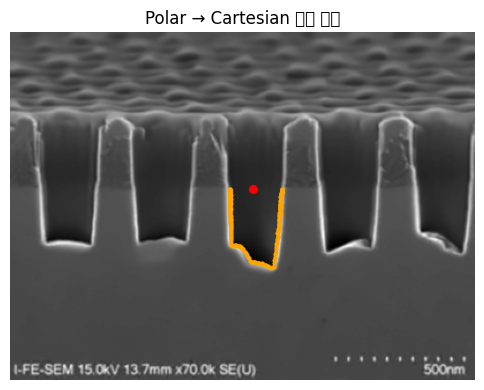

In [4]:
# ====== Polar (r, angle_deg) → Cartesian (x,y) 변환 ======
CONVERTED_CSV = OUTPUT_CSV.replace(".csv", "_cartesian.csv")

cart_rows = []
for r in results:
    ang = r["angle_deg"]
    rr  = r["r_pixels"]
    rad = math.radians(ang)   # 0°=+x, 시계(clockwise) 증가 기준
    x_c = src_x + rr * math.cos(rad)
    y_c = src_y + rr * math.sin(rad)
    cart_rows.append({
        "angle_deg": ang,
        "r_pixels": rr,
        "x_cart": float(x_c),
        "y_cart": float(y_c),
        # 참조용으로 기존 검출 좌표도 같이 남김
        "x_detected": r.get("x", float(x_c)),
        "y_detected": r.get("y", float(y_c)),
        "method": r.get("method", ""),
        "value": r.get("value", np.nan),
    })

# CSV 저장
with open(CONVERTED_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(cart_rows[0].keys()))
    writer.writeheader()
    writer.writerows(cart_rows)

print("Cartesian CSV 저장 완료:", CONVERTED_CSV)

# 시각화 (Cartesian 궤적 확인)
xs = [row["x_cart"] for row in cart_rows]
ys = [row["y_cart"] for row in cart_rows]
plt.figure(figsize=(6,6))
plt.imshow(img_proc, cmap="gray")
plt.scatter([src_x],[src_y], s=30, c="red")
plt.plot(xs, ys, "-o", markersize=2, c="orange")
plt.title("Polar → Cartesian 변환 궤적")
plt.axis("off"); plt.show()
